# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/Users/sio.c/.pyenv/versions/3.12.0/envs/myproject/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)



**1.1:**  What is the objective of this project in business terms?


The primary objective of this project is to predict the assessed tax value (taxvaluedollarcnt) of properties using the Zillow dataset.

One of our team members has experience in the mortgage industry and has utilized Zillow for data gathering during home purchases. A key aspect of Zillow's business model is to provide inforamtion about real estate to consumers and connect consumers with real estate professionals (https://www.zillow.com/professionals/real-estate-agent-reviews/). As Zillow's predicted values become more reliable, consumer trust will likely increase, leading to higher usage rates by consumers. This increase in consumer engagement can be leveraged in marketing promotions to attract more real estate professionals—such as agents and brokers—to partner with Zillow as a premier agent or advertisers, which in turn will generate more income for the company.


**1.2:**  How will your solution be used?


By developing a reliable regression model, Zillow can get more accurate property valuations (assessed tax value). With better predictions, this business initiative could support the marketing team target their campaigns to increase traffic to the website, as the data will be more accurate than competitors and understand which features drive value. The analysis provides a clearer picture of the factors influencing property assessments.


From a consumer perspective, many consumers use Zillow to research potential properties to purchase, including estimated sales prices ranges so they can understand if a property may be in their price range or not. Our marketing team could leverage the accuracy of our data driven models as a leverage tool when marketing Zillow to Real Estate agents and expand our consumer base.

**1.3:**  How should success (or failure) be measured?


Success or failure could be measured is by how accurate our prediction was when comparing it to the actual sales price of the property. This analysis could be completed within months of a property being sold, providing feedback we could ingest and analyze to understand if there were features in our data that were inaccurately represented, allowing us to refine our model further. From a marketing persepctive, we could evaluate if the targeted marketing campaings resulted in an increase or decrease to new accounts being opened with real estate agents, traffic to the website, or other indicators.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [ ]:
# 1.quick look at the first few rows
print(df.head())

# 2. basic DataFrame info: columns, data types, non-null counts
print(df.info())

5# 3. number of unique values in each column
print(df.nunique())

# 4. identifying count of missing values per column
missing_values = df.isna().sum()
print("Missing Values Per Column:\n", missing_values[missing_values > 0])

# 5. identifies when there is only one unique value and may not be helpful
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"Feature '{column}' has only one unique value and may be useless.")

   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildingsqft26  \
0    

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

* Object-type columns such as hashottuborspa, propertycountylandusecode, propertyzoningdesc, fireplaceflag, and taxdelinquencyflag appear to be categorical (strings or flags).
* Some numeric columns have very few unique values (e.g., regionidcounty with only 3 unique values) and may also be treated as categorical codes rather than continuous numeric features.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

* ID-like fields such as parcelid typically don’t help predict tax value directly.
* Highly specialized codes (e.g., rawcensustractandblock) may not provide clear insight unless you plan to incorporate external data on census blocks.
* Rare flags (e.g., fireplaceflag, which has only 172 non-null entries) might have limited predictive value unless domain knowledge suggests otherwise.
* See #5 in the code above, which identifies when there is only one unique value and may not be helpful.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

* Columns with extremely few non-null entries—like basementsqft (50 non-null), storytypeid (50 non-null), yardbuildingsqft26 (70 non-null), and buildingclasstypeid (15 non-null)—are strong candidates for removal.
* These columns are missing data for nearly the entire dataset, making them difficult to use effectively.
* Here is a list of the specific values that are filled vs. missing:
 - basementsqft – Only 50 non-null values out of 77,613 (~0.06% filled, ~99.94% missing).
 - buildingclasstypeid – Only 15 non-null values (~99.98% missing).
 - finishedsquarefeet13 – Only 42 non-null values (~99.95% missing).
 - storytypeid – Only 50 non-null values (~99.94% missing).
 - typeconstructiontypeid – Only 223 non-null values (~99.7% missing).

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

* Numeric codes such as fips, regionidcity, regionidcounty, and propertylandusetypeid appear numeric but may function more like categorical IDs.
* Skewed continuous features (e.g., taxvaluedollarcnt and other square footage columns) might benefit from transformations (like a log transform) to reduce the impact of outliers and high skew.
* See #5 in the code above, which identifies when there is only one unique value and may not be helpful.


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 2000x5700 with 0 Axes>

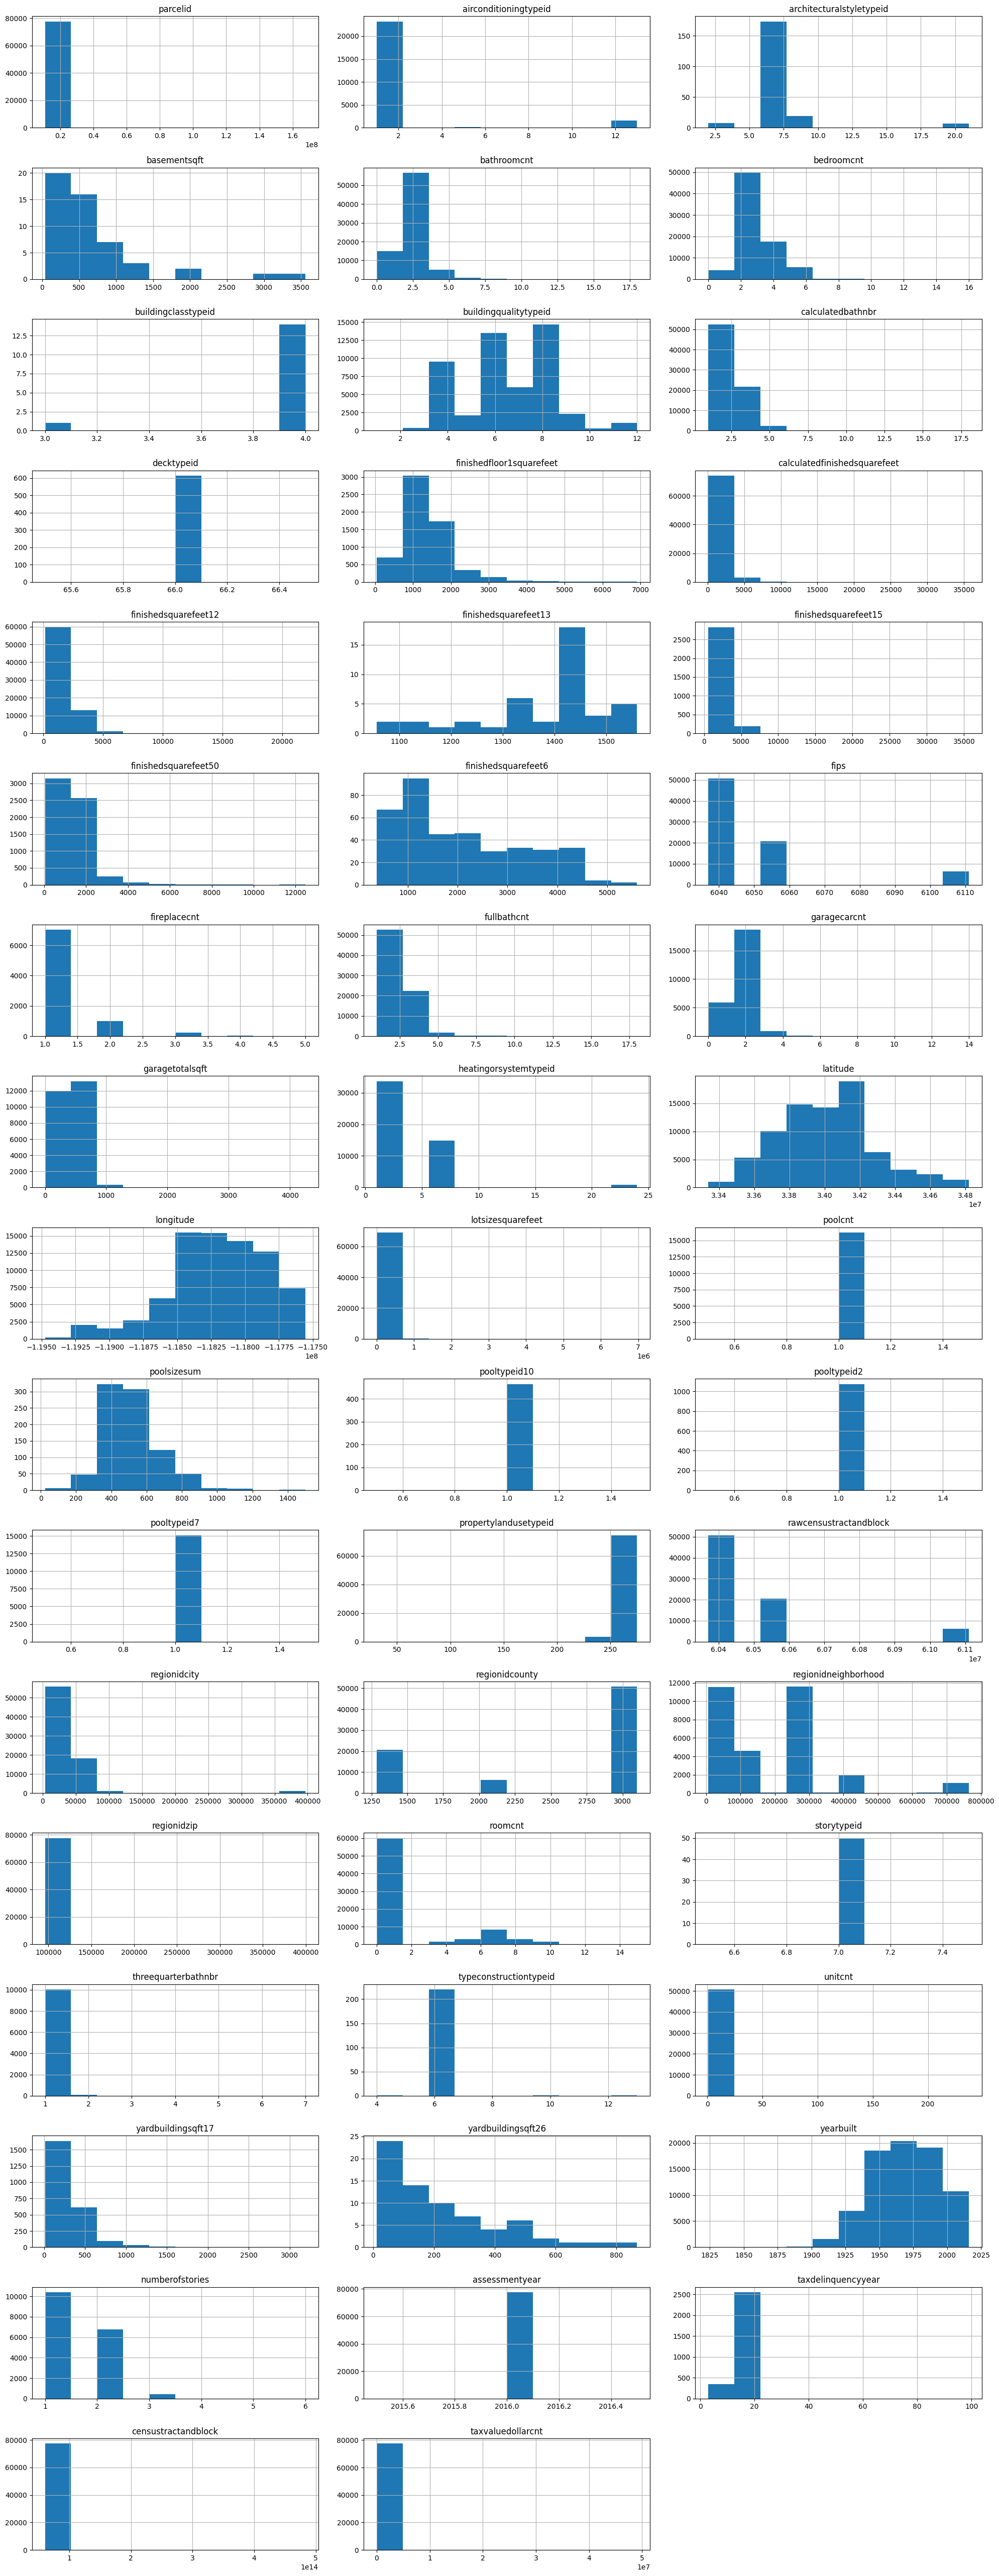

In [4]:
#layout: 3 columns per row, compute number of rows
num_cols = 3
num_rows = int(np.ceil(len(df.columns) / num_cols))

plt.figure(figsize=(20, num_rows * 3))
df.hist(figsize=(20, num_rows * 3), layout=(num_rows, num_cols))
plt.tight_layout()
plt.show()


**Individual Visualizations for the Target and Three Selected Features**

Below are  the separate visualizations (using histograms and boxplots) for the target variable and three interesting features.
* Target: taxvaluedollarcnt

Three selected features--
* 1: bathroomcnt
* 2: bedroomcnt
* 3: yearbuilt
* 4: log-transformed (optional)

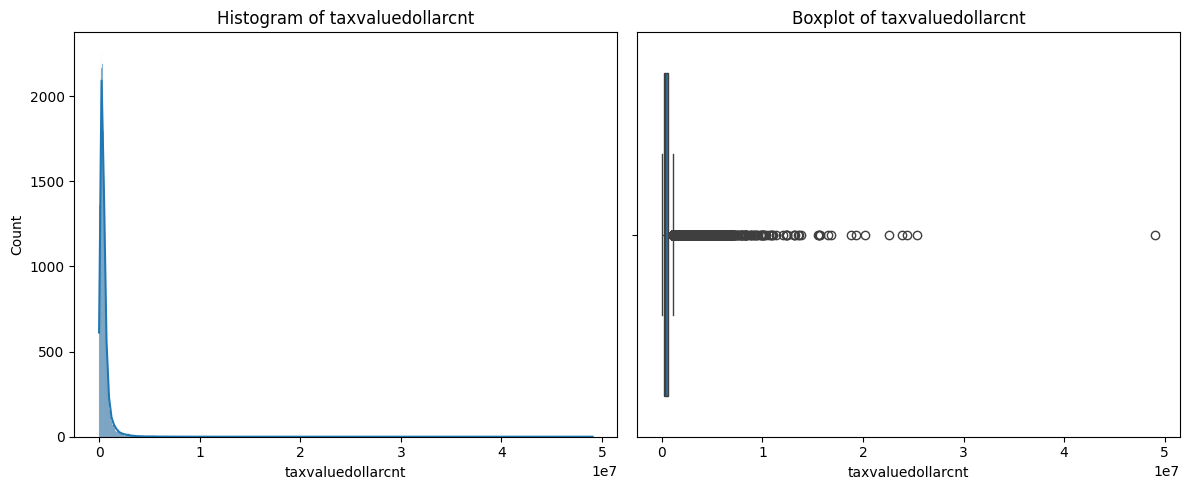

In [5]:
#Visualizing the Target: taxvaluedollarcnt

#histogram/boxplot for the target variable --- taxvaluedollarcnt
plt.figure(figsize=(12, 5))

#histogram w/KDE to show distribbution
plt.subplot(1, 2, 1)
sns.histplot(df['taxvaluedollarcnt'], kde=True)
plt.title('Histogram of taxvaluedollarcnt')

#used boxplt to show outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['taxvaluedollarcnt'])
plt.title('Boxplot of taxvaluedollarcnt')

plt.tight_layout()
plt.show()


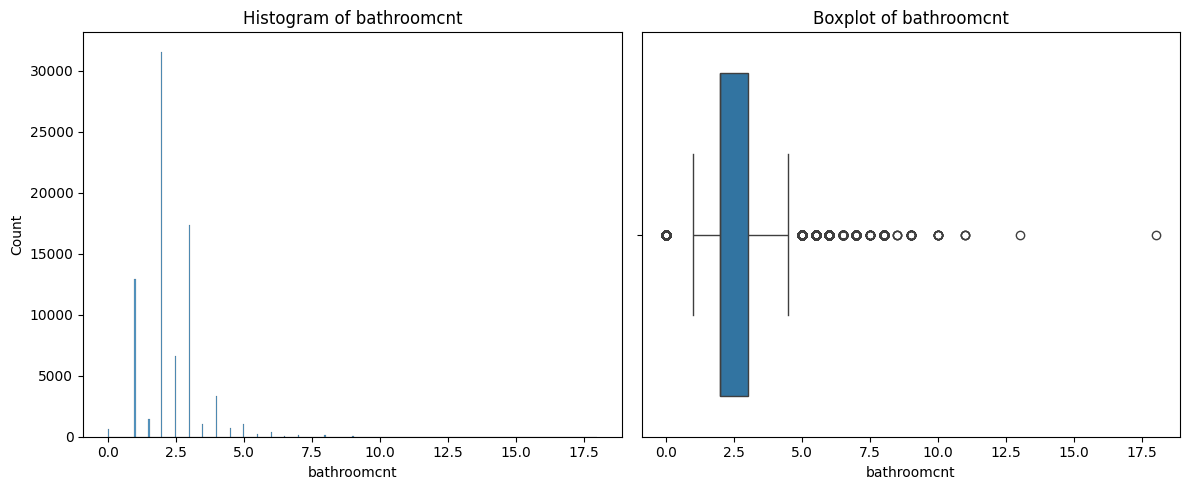

In [6]:
#feature 1 -- bathroomcnt

#histogram/boxplot for bathroomcnt
plt.figure(figsize=(12, 5))

#histogram - couldn't use KDE since discreete features
plt.subplot(1, 2, 1)
sns.histplot(df['bathroomcnt'], kde=False)
plt.title('Histogram of bathroomcnt')

#boxplot to show outlier
plt.subplot(1, 2, 2)
sns.boxplot(x=df['bathroomcnt'])
plt.title('Boxplot of bathroomcnt')

plt.tight_layout()
plt.show()


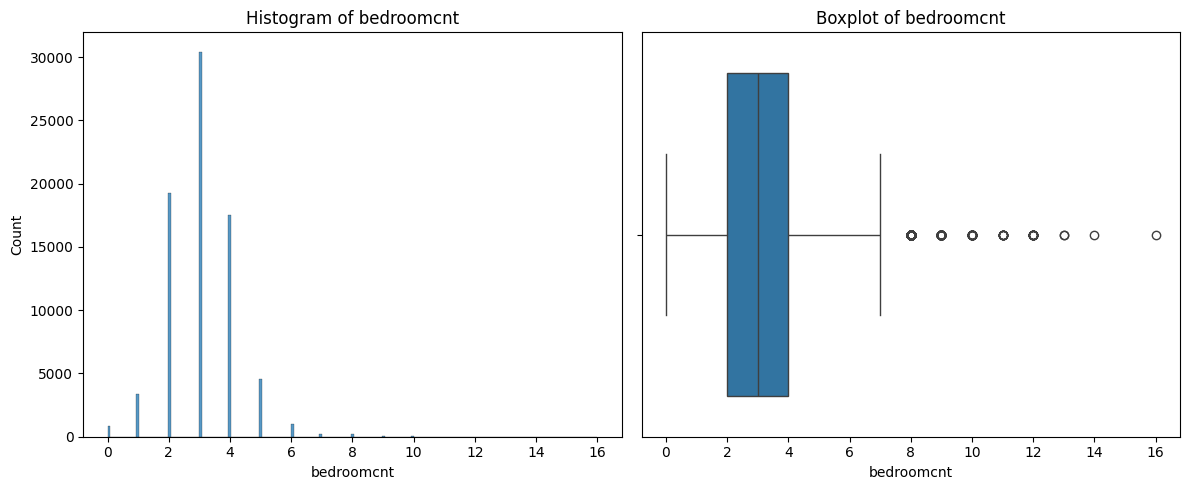

In [7]:
#feature 2 — bedroomcnt

#histogram/boxplot for bedroomcnt
plt.figure(figsize=(12, 5))

# Histogram — shows distribution of bedroomcnt
plt.subplot(1, 2, 1)
sns.histplot(df['bedroomcnt'], kde=False)
plt.title('Histogram of bedroomcnt')

#boxplot to show outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['bedroomcnt'])
plt.title('Boxplot of bedroomcnt')

plt.tight_layout()
plt.show()

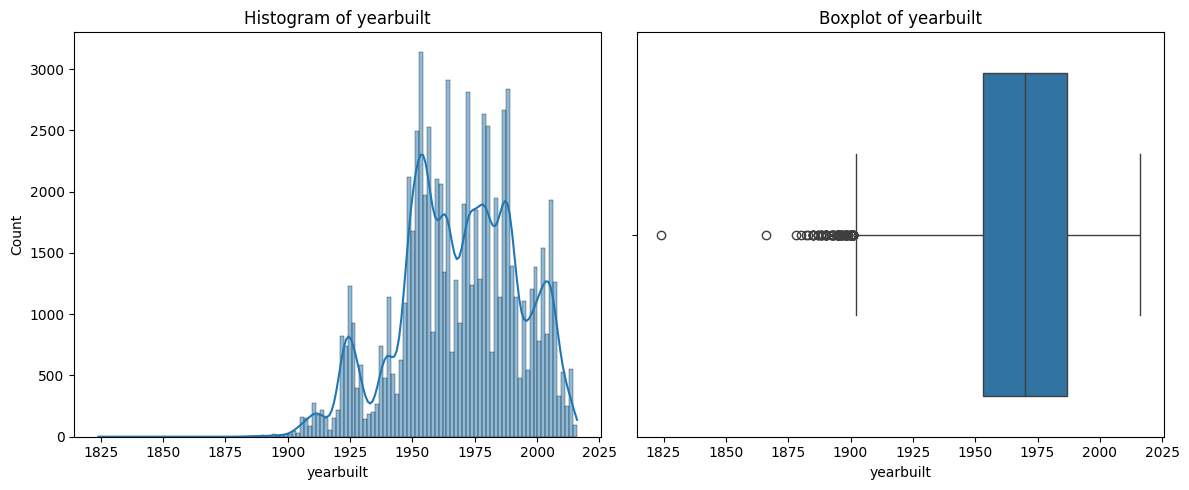

In [8]:
#feature 3 - year built

# histogram/boxplot for yearbuilt
plt.figure(figsize=(12, 5))

#histogram w/KDE to show distribution
plt.subplot(1, 2, 1)
sns.histplot(df['yearbuilt'], kde=True)
plt.title('Histogram of yearbuilt')

#boxplot to show outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['yearbuilt'])
plt.title('Boxplot of yearbuilt')

plt.tight_layout()
plt.show()


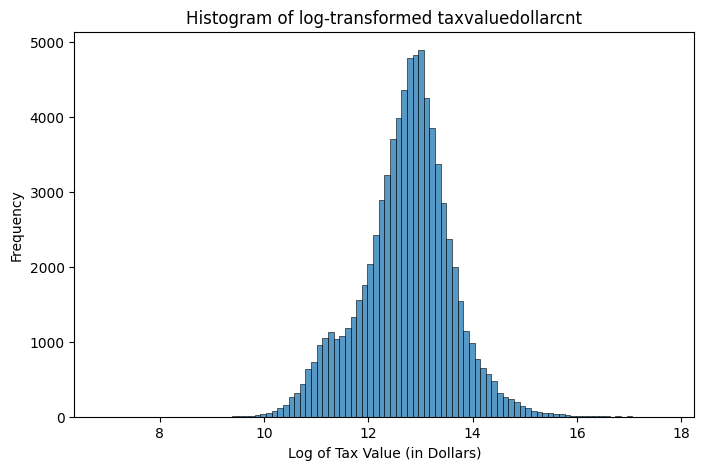

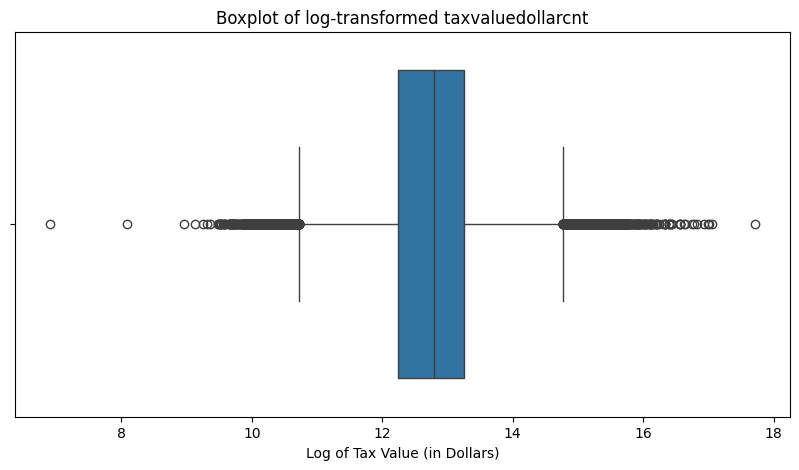

In [9]:
#
df['log_taxvaluedollarcnt'] = np.log1p(df['taxvaluedollarcnt'])

# Plot histogram of the log-transformed data
plt.figure(figsize=(8, 5))
sns.histplot(df['log_taxvaluedollarcnt'], bins=100, edgecolor='black')
plt.title('Histogram of log-transformed taxvaluedollarcnt')
plt.xlabel('Log of Tax Value (in Dollars)')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot of the log-transformed data
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['log_taxvaluedollarcnt'])
plt.title('Boxplot of log-transformed taxvaluedollarcnt')
plt.xlabel('Log of Tax Value (in Dollars)')
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


**Explanation broken down by target and feataures**

Target — taxvaluedollarcnt:
The histogram for taxvaluedollarcnt shows a highly right-skewed distribution, indicating that while most properties have moderate tax values, there are a few with extremely high values that could be considered outliers. The boxplot reinforces this observation, suggesting that a transformation (such as a logarithmic scale) might be beneficial when modeling.

In our review, we found that the target variable, taxvaluedollarcnt, exhibits a highly right-skewed (exponential-like) distribution, where most properties fall into a moderate range but a few outliers drive up the mean significantly.

In contrast, features like bathroomcnt and bedroomcnt show more compact, discrete distributions with most values clustered around typical counts for residential properties, indicating fewer outliers and a categorical-like nature.

The yearbuilt feature reveals a broader spread, reflecting different construction eras with some older properties standing out as potential outliers.

As a team, we additionally decided to include the a log transformation to obtain a nicer, bell-shaped curve.

We chose these features because they provide varied insights into the housing market: while the target's skew suggests that transformations may be necessary, the count features and year of construction highlight important trends and potential predictive signals that are directly relevant to property valuation.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [10]:
# drop columns not needed / unsuitable
def drop_unfit_features(df, columns_to_drop):
    return df.drop(columns=columns_to_drop, errors='ignore')

#ID column, not useful for regression - to be removed in addition to the others noted below
columns_to_remove = [
    'parcelid',
    'assessmentyear',                   # Not directly useful
        'storytypeid',                  # Not directly useful
        'unitcnt',                      # Not directly useful
        'yardbuildingsqft17',           # Not directly useful
        'yardbuildingsqft26',           # Not directly useful
        'transactiondate',              # Not directly useful
]

df_unfit_dropped = drop_unfit_features(df, columns_to_remove)

print("list of remaining col after dropping parcelid:")
print(df_unfit_dropped.columns.tolist())


list of remaining col after dropping parcelid:
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'typeconstructiontypeid', 'yearbuilt', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'taxva

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop.


We decided to drop the following columns:
-     assessmentyear               
-     storytypeid                
-     unitcnt                    
-     yardbuildingsqft17
-     yardbuildingsqft26
-     transactiondate           


  The reason is due to the fields not contributing predictive value to our regression model. This step ensures we focus on features that have a direct or indirect relationship to taxvaluedollarcnt and reduce noise that could negatively impact the modeling process.



### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

In [11]:
#drops columns where the proportion of non-null values is below the given threshold of 50%.
def drop_high_null_features(df, threshold=0.5):
    non_null_ratio = df.notnull().mean()
    # Identify columns to drop
    cols_to_drop = non_null_ratio[non_null_ratio < threshold].index
    # Ensure we don't drop the target
    if 'taxvaluedollarcnt' in cols_to_drop:
        cols_to_drop = cols_to_drop.drop('taxvaluedollarcnt')
    # Print dropped columns
    print("Dropped columns due to high nulls:", list(cols_to_drop))
    return df.drop(columns=cols_to_drop)

# Apply the function to df_unfit_dropped
df_nulls_dropped = drop_high_null_features(df_unfit_dropped, threshold=0.5)
print("Columns remaining after dropping features with too many nulls:")
print(df_nulls_dropped.columns.tolist())


Dropped columns due to high nulls: ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'threequarterbathnbr', 'typeconstructiontypeid', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']
Columns remaining after dropping features with too many nulls:
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', '

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



Our team selected a 50% threshold for non-null values because columns missing more than half of their data are likely to cause uncertainty. Retaining them could distort the dataset and lead to unreliable modeling. By removing these features, we focus on columns that provide enough valid observations to support our regression task.

### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [12]:
#drops rows that have a null target value and more than row_null_threshold fraction of missing values.

def drop_problematic_samples(df, row_null_threshold=0.2):
    # drop rows missing the target
    df_clean = df.dropna(subset=['taxvaluedollarcnt']).copy()

    #drop rows that exceed the row_null_threshold
    row_missing_fraction = df_clean.isnull().mean(axis=1)
    df_clean = df_clean[row_missing_fraction <= row_null_threshold]

    return df_clean

#dropsrows where 'taxvaluedollarcnt' is an outlier, using IQR.
def drop_target_outliers(df):
    Q1 = df['taxvaluedollarcnt'].quantile(0.25)
    Q3 = df['taxvaluedollarcnt'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df['taxvaluedollarcnt'] >= lower_bound) & (df['taxvaluedollarcnt'] <= upper_bound)]

# Apply these functions in order
df_problematic_dropped = drop_problematic_samples(df_nulls_dropped, row_null_threshold=0.2)
df_problematic_dropped = drop_target_outliers(df_problematic_dropped)

print("Shape after dropping samples:", df_problematic_dropped.shape)


Shape after dropping samples: (71802, 24)


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


Our team decided on the following steps:

1. Removed rows where the target was null because they are unusable for training a supervised model.

2. Any row missing more than 20% of its feature values was dropped, as such adding substantial values can undermine data integrity.

3. We filtered out extreme outliers in taxvaluedollarcnt using the IQR method to avoid skewing the regression model.

Additional note: The IQR method was selected because it provides a robust way to detect outliers without assuming a specific distribution. By focusing on the middle 50% of the data (between the first and third quartiles), it minimizes the impact of extreme values that might skew the analysis. This method is straightforward to implement and interpret—values falling more than 1.5 times the IQR below Q1 or above Q3 are flagged as outliers. This makes it particularly useful for datasets like ours, where the target variable can be highly skewed, ensuring that extreme values don't disproportionately affect the model's performance.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [13]:
#imputes missing values. Numeric columns; median. Categorical columns; mode (or 'Unknown' if mode doesn't exist)
#should return new df with no missing values.
def impute_missing_values(df):
    # make deep copy to avoid SettingWithCopyWarning -- this required due to pandas warning
    df_imputed = df.copy(deep=True)

    #show numeric and categorical columns
    numeric_cols = df_imputed.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object']).columns.tolist()

    #impute numeric columns with median
    for col in numeric_cols:
        median_val = df_imputed[col].median()
        df_imputed.loc[:, col] = df_imputed[col].fillna(median_val)

    #impute categorical columns with mode or 'Unknown'
    for col in categorical_cols:
        if not df_imputed[col].mode().empty:
            mode_val = df_imputed[col].mode()[0]
        else:
            mode_val = 'Unknown'
        df_imputed.loc[:, col] = df_imputed[col].fillna(mode_val)

    return df_imputed

df_imputed_final = impute_missing_values(df_problematic_dropped)
print("remaining missing values", df_imputed_final.isnull().sum().sum())


remaining missing values 0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


We used the median for numeric features because it reduces the impact of outliers, which can skew the mean. For categorical features, we used the mode to preserve the most common category. This approach ensures the dataset remains consistent without introducing too much bias.

### 3.E: Encode the Categorical Features (if any)



You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [14]:
#encodes categorical features using OrdinalEncoder.

def encode_categorical_features(df):
    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

    if cat_cols:
        encoder = OrdinalEncoder()
        df_encoded[cat_cols] = encoder.fit_transform(df_encoded[cat_cols])

    return df_encoded

df_final = encode_categorical_features(df_imputed_final)

print("confirm data types after encoding:")
print(df_final.dtypes)


confirm data types after encoding:
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fullbathcnt                     float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode       float64
propertylandusetypeid           float64
propertyzoningdesc              float64
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidzip                     float64
roomcnt                         float64
yearbuilt                       float64
censustractandblock             float64
taxvaluedollarcnt               float64
log_taxvaluedollarcnt           float64
dtype

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

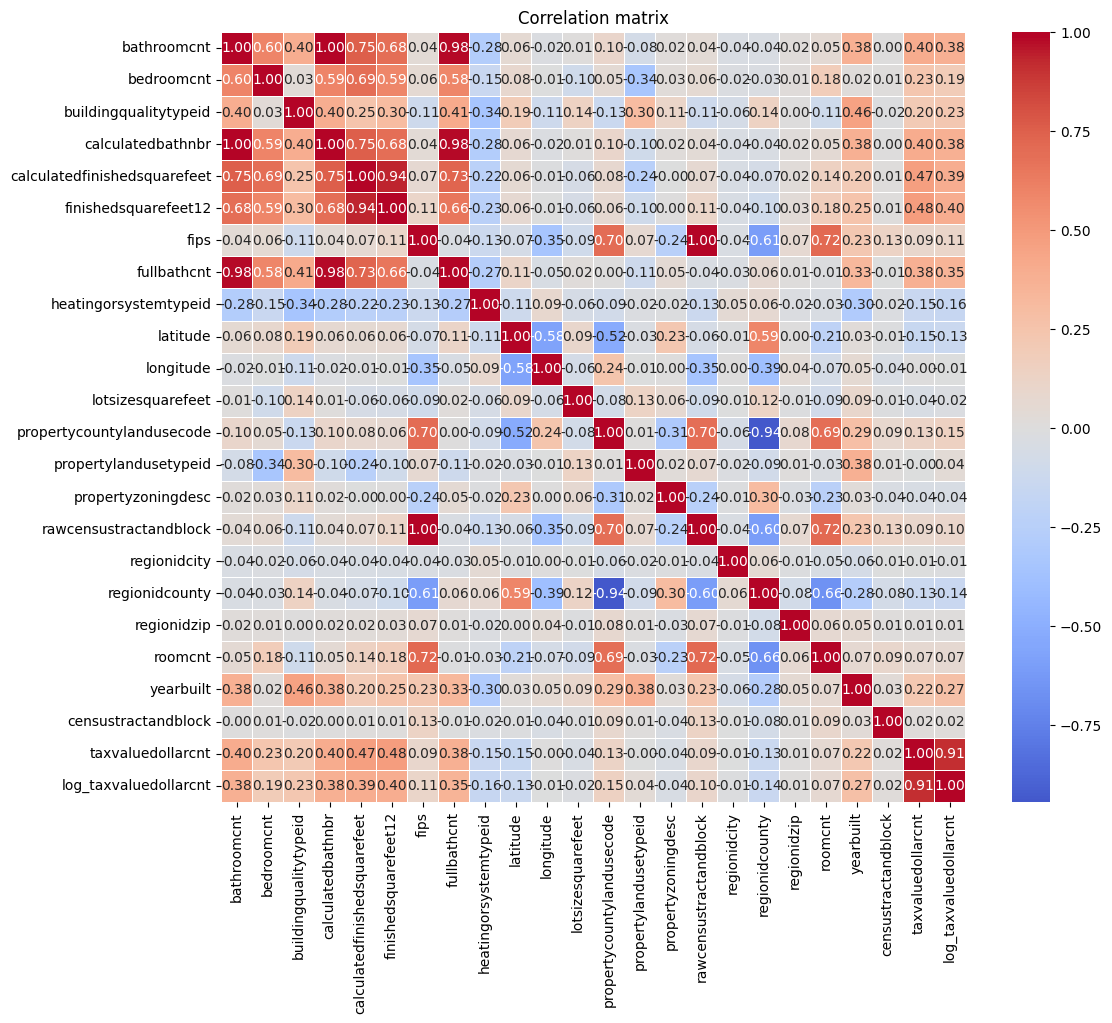

Correlations with taxvaluedollarcnt:
taxvaluedollarcnt               1.000000
log_taxvaluedollarcnt           0.912854
finishedsquarefeet12            0.481372
calculatedfinishedsquarefeet    0.474991
calculatedbathnbr               0.404247
bathroomcnt                     0.403759
fullbathcnt                     0.376268
bedroomcnt                      0.234772
yearbuilt                       0.221392
buildingqualitytypeid           0.203163
propertycountylandusecode       0.125515
fips                            0.091105
rawcensustractandblock          0.089776
roomcnt                         0.071534
censustractandblock             0.015561
regionidzip                     0.005740
longitude                      -0.000889
propertylandusetypeid          -0.003665
regionidcity                   -0.005951
propertyzoningdesc             -0.043125
lotsizesquarefeet              -0.043649
regionidcounty                 -0.134728
heatingorsystemtypeid          -0.145251
latitude            

In [15]:
from scipy import stats

#Part 4.A: Compute and analyze pairwise correlations using a correlation matrix.

#calc orrelation matrix for numeric columns
#using df_final since it is the cleaned & encoded dataset
corr_matrix = df_final.corr()

#show the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation matrix")
plt.show()

#identify correlation with the target variable
target_correlations = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
print("Correlations with taxvaluedollarcnt:")
print(target_correlations)


F-statistics and p-values by feature
                         Feature    F-Statistic        p-value
22         log_taxvaluedollarcnt  358917.959280   0.000000e+00
5           finishedsquarefeet12   21655.441976   0.000000e+00
4   calculatedfinishedsquarefeet   20918.901690   0.000000e+00
3              calculatedbathnbr   14025.205749   0.000000e+00
0                    bathroomcnt   13984.742150   0.000000e+00
7                    fullbathcnt   11841.795824   0.000000e+00
1                     bedroomcnt    4188.301542   0.000000e+00
20                     yearbuilt    3700.619998   0.000000e+00
2          buildingqualitytypeid    3091.153211   0.000000e+00
9                       latitude    1694.128110   0.000000e+00
8          heatingorsystemtypeid    1547.467893   0.000000e+00
17                regionidcounty    1327.382961  5.476608e-288
12     propertycountylandusecode    1149.251031  6.227150e-250
6                           fips     600.933369  3.678237e-132
15        rawcensu

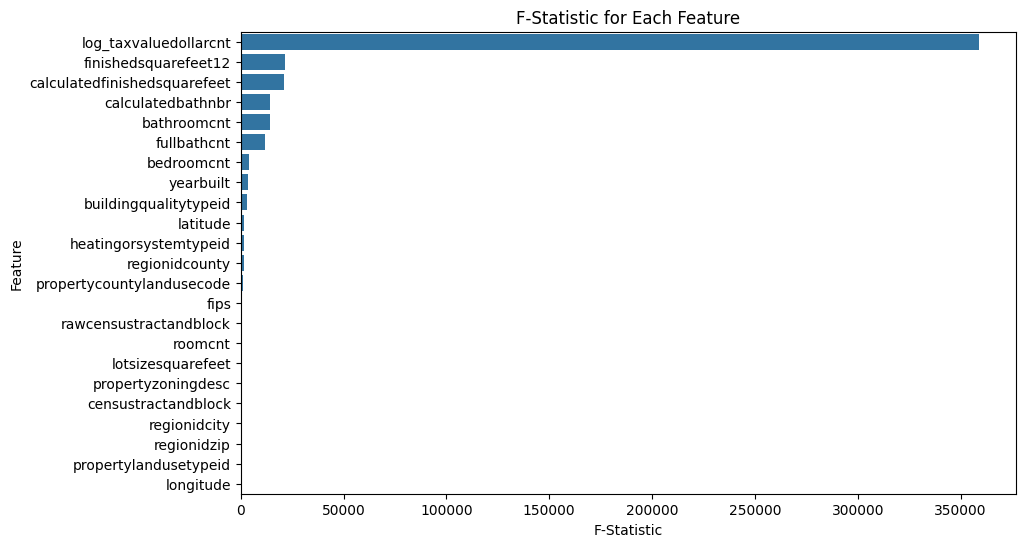

In [16]:
#Part 4.A: Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).

#separate the features (X) and the target (y)
X = df_final.drop(columns=['taxvaluedollarcnt'])
y = df_final['taxvaluedollarcnt']

#compute F-statistics and p-values
f_stats, p_values = f_regression(X, y)

#organize results in a DataFrame
feature_names = X.columns
f_results = pd.DataFrame({'Feature': feature_names, 'F-Statistic': f_stats, 'p-value': p_values})
f_results.sort_values('F-Statistic', ascending=False, inplace=True)

print("F-statistics and p-values by feature")
print(f_results)

#bar plot of F-stats
plt.figure(figsize=(10, 6))
sns.barplot(data=f_results, x='F-Statistic', y='Feature', orient='h')
plt.title('F-Statistic for Each Feature')
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

model = LinearRegression()


# Prepare feature matrix X and target vector y
X = df_final.drop(columns=['taxvaluedollarcnt'])
y = df_final['taxvaluedollarcnt']

# Define your model
model = LinearRegression()

# Forward selection
sfs_forward = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward', scoring='r2', cv=5)
sfs_forward.fit(X, y)
forward_features = X.columns[sfs_forward.get_support()]
print("Forward selected features:")
print(forward_features)

# Backward selection
sfs_backward = SequentialFeatureSelector(model, n_features_to_select=10, direction='backward', scoring='r2', cv=5)
sfs_backward.fit(X, y)
backward_features = X.columns[sfs_backward.get_support()]
print("Backward selected features:")
print(backward_features)

Forward selected features:
Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'latitude', 'longitude',
       'propertycountylandusecode', 'roomcnt', 'yearbuilt',
       'log_taxvaluedollarcnt'],
      dtype='object')
Backward selected features:
Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'latitude', 'longitude',
       'propertycountylandusecode', 'regionidcounty', 'yearbuilt',
       'log_taxvaluedollarcnt'],
      dtype='object')


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



From the correlation matrix, we see that features like finishedsquarefeet12 and calculatedfinishedsquarefeet have the highest positive correlations with taxvaluedollarcnt, suggesting that properties with larger finished square footage tend to have higher assessed tax values.

Both bedroomcnt and bathroomcnt also show moderately strong correlations, aligning with the intuition that more rooms often mean higher valuations. Also, when there is a higher count of squarefootage there is, the an increase in a higher count of bedrooms since there is more space.

The buildingqualitytypeid appears negatively correlated with the target, indicating that it may not be as straightforward or that higher “quality” codes might reflect different property characteristics than we expected.

Turning to the F-statistics, finishedsquarefeet12 again tops the list, followed by calculatedfinishedsquarefeet, bedroomcnt, and bathroomcnt, confirming these features strong relationships with the target.

Meanwhile, features like assessmentyear and taxdelinquencyflag rank low on both correlation and F-stat measures, suggesting they may not add significant predictive value. Taxes being deliquent could potentially be removed.

Overall, these findings highlight the importance of square footage and room counts for predicting property tax values while also identifying a few features that may warrant further investigation or eventually removed.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

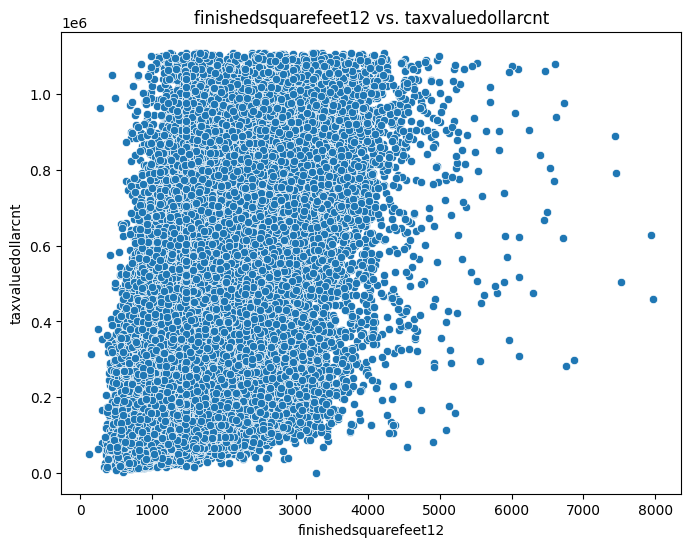

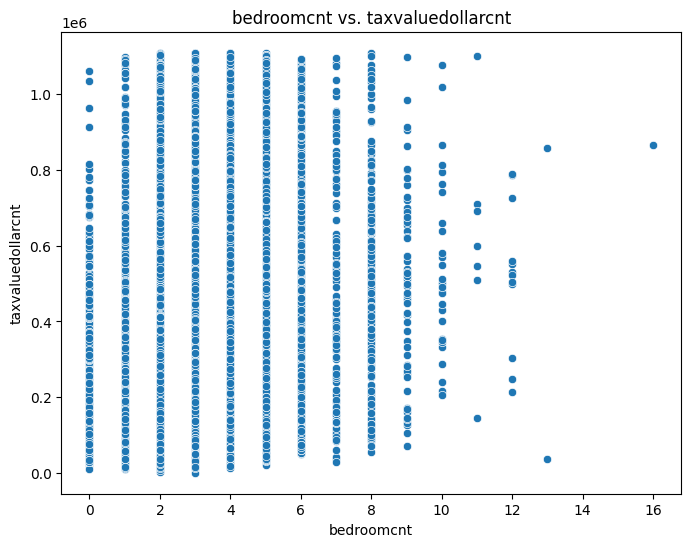

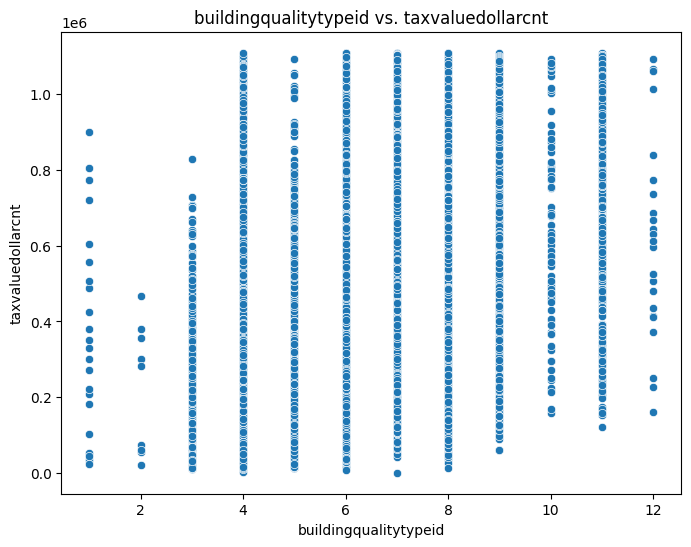

In [18]:
#selected 3 pairs to visualize
feature_pairs = [
    ("finishedsquarefeet12", "taxvaluedollarcnt"),
    ("bedroomcnt", "taxvaluedollarcnt"),
    ("buildingqualitytypeid", "taxvaluedollarcnt")
]

for feat_x, feat_y in feature_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_final[feat_x], y=df_final[feat_y])
    plt.title(f"{feat_x} vs. {feat_y}")
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.show()


<Figure size 1200x1200 with 0 Axes>

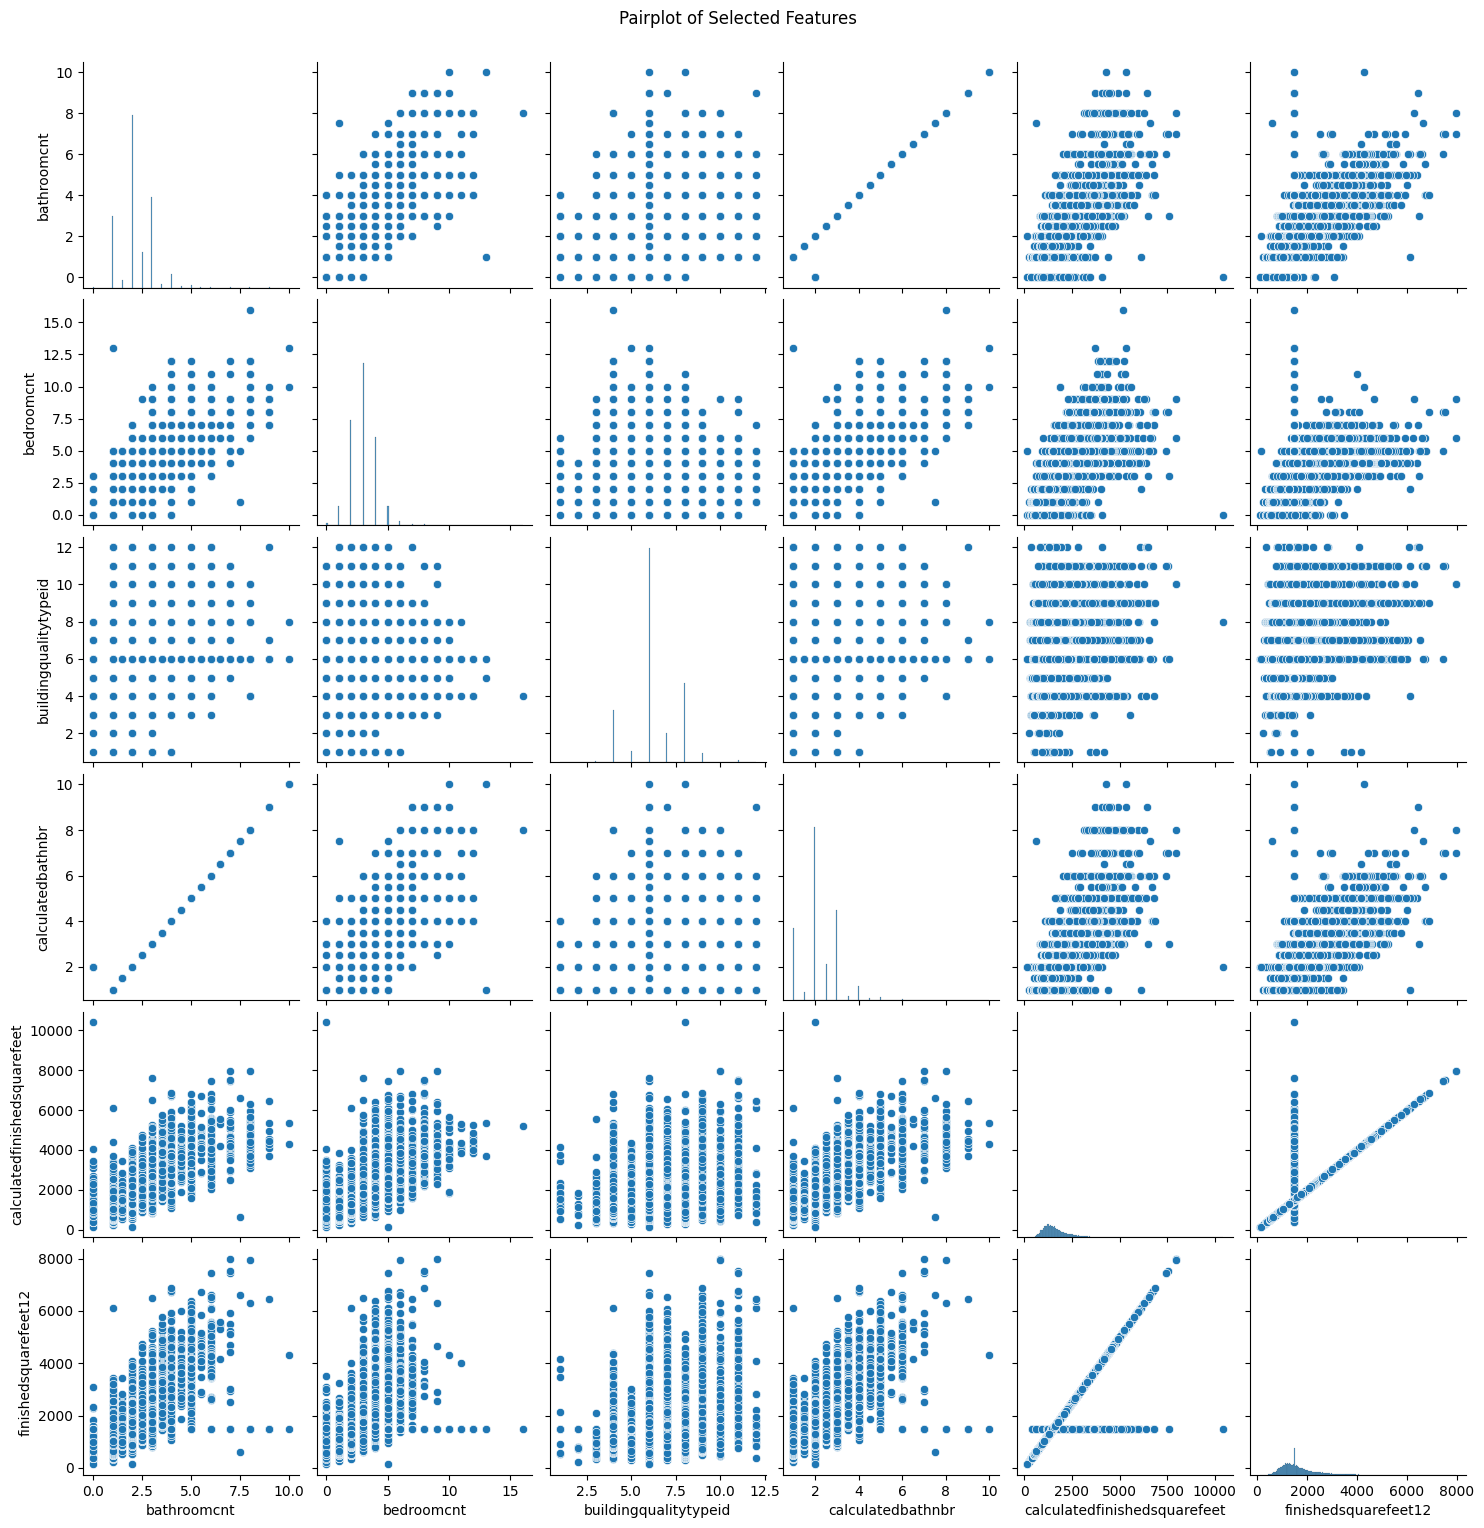

In [19]:
#added 4th option of pairplots of selected feataures
plt.figure(figsize=(12, 12))
features = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12']
selected_data = X[features]

sns.pairplot(selected_data)

plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.

Observed patterns from the three scatter plots:
* finishedsquarefeet12 vs. taxvaluedollarcnt
    * There is a clear upward trend indicating that properties with greater finished square footage often have higher tax values.
    * Beyond a certain square footage, data points become more scattered, suggesting fewer properties in that upper range.
* bedroomcnt vs. taxvaluedollarcnt
    * Although there is a general increase in tax value with more bedrooms, the relationship is not as tight as square footage.
    * Some properties have a high bedroom count but relatively lower tax values, indicating other factors may play a role.
* buildingqualitytypeid vs. taxvaluedollarcnt
    * The relationship appears weaker compared to square footage and bedroom count.
    * Properties with the same quality code can still span a broad range of tax values, suggesting that building quality alone does not strongly determine tax valuation.


These observations support the findings from the correlation matrix and F-statistics, illustrating how certain features (particularly those tied to size) have a stronger linear relationship with the target, whereas others may need deeper investigation or feature engineering to capture their influence on tax valuations.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

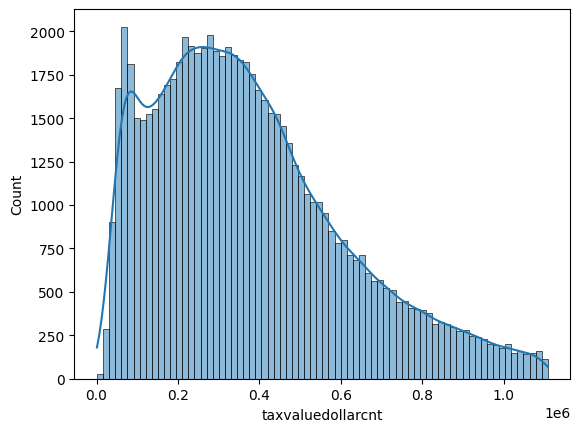

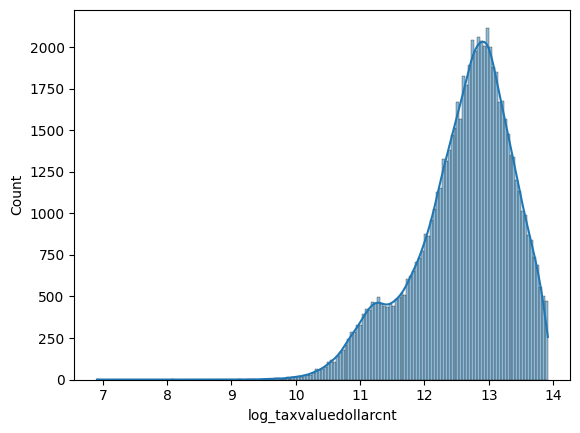

In [20]:
#First transformatiom: Log transform of target

#create copy to avoid overwriting original
df_transformed = df_final.copy()

#apply log1p to handle zeros safely
df_transformed['log_taxvaluedollarcnt'] = np.log1p(df_transformed['taxvaluedollarcnt'])

#compare distributions -- histograms before/after to show how data was transformed:
sns.histplot(df_final['taxvaluedollarcnt'], kde=True); plt.show()
sns.histplot(df_transformed['log_taxvaluedollarcnt'], kde=True); plt.show()


In [21]:
print(df_transformed.columns.tolist())


['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt', 'censustractandblock', 'taxvaluedollarcnt', 'log_taxvaluedollarcnt']


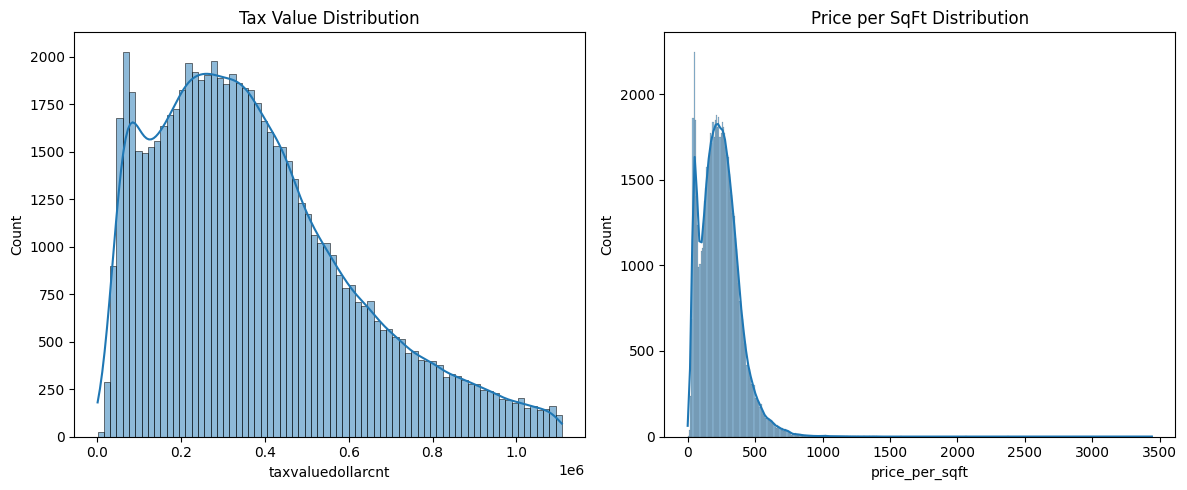

In [22]:
#Second transformation: Derived feature: price per squarefoot

# create copy so we don't modify the original DataFrame
df_transformed = df_final.copy(deep=True)

#create the 'price_per_sqft' feature
price_per_sqft = df_transformed['taxvaluedollarcnt'].div(
    df_transformed['finishedsquarefeet12'].replace(0, np.nan)
)
df_transformed['price_per_sqft'] = price_per_sqft.fillna(0)

#plot distributions of taxvaluedollarcnt vs. price_per_sqft
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df_transformed, x='taxvaluedollarcnt', kde=True, ax=axes[0])
axes[0].set_title('Tax Value Distribution')

sns.histplot(data=df_transformed, x='price_per_sqft', kde=True, ax=axes[1])
axes[1].set_title('Price per SqFt Distribution')

plt.tight_layout()
plt.show()





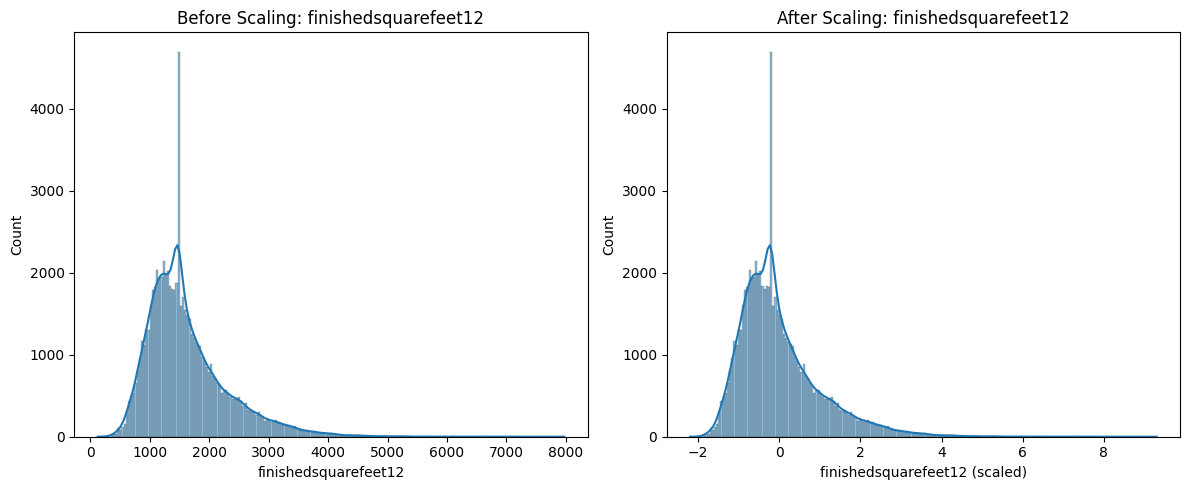

In [23]:
#Third transformation: Standard scaling of numeric features
# Create a deep copy of our DataFrame (which already includes our derived features)
df_scaled = df_transformed.copy(deep=True)

# Identify numeric columns. Exclude target columns: 'taxvaluedollarcnt' and its log version.
numeric_cols = df_scaled.select_dtypes(include=['number']).columns.tolist()
exclude_cols = ['taxvaluedollarcnt', 'log_taxvaluedollarcnt']
numeric_cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]

# Initialize and apply StandardScaler
scaler = StandardScaler()
df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

# Plot comparison for one representative feature (e.g., finishedsquarefeet12)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before scaling: Distribution from the original df_transformed
sns.histplot(df_transformed['finishedsquarefeet12'], kde=True, ax=axes[0])
axes[0].set_title('Before Scaling: finishedsquarefeet12')
axes[0].set_xlabel('finishedsquarefeet12')

# After scaling: Distribution from df_scaled
sns.histplot(df_scaled['finishedsquarefeet12'], kde=True, ax=axes[1])
axes[1].set_title('After Scaling: finishedsquarefeet12')
axes[1].set_xlabel('finishedsquarefeet12 (scaled)')

plt.tight_layout()
plt.show()

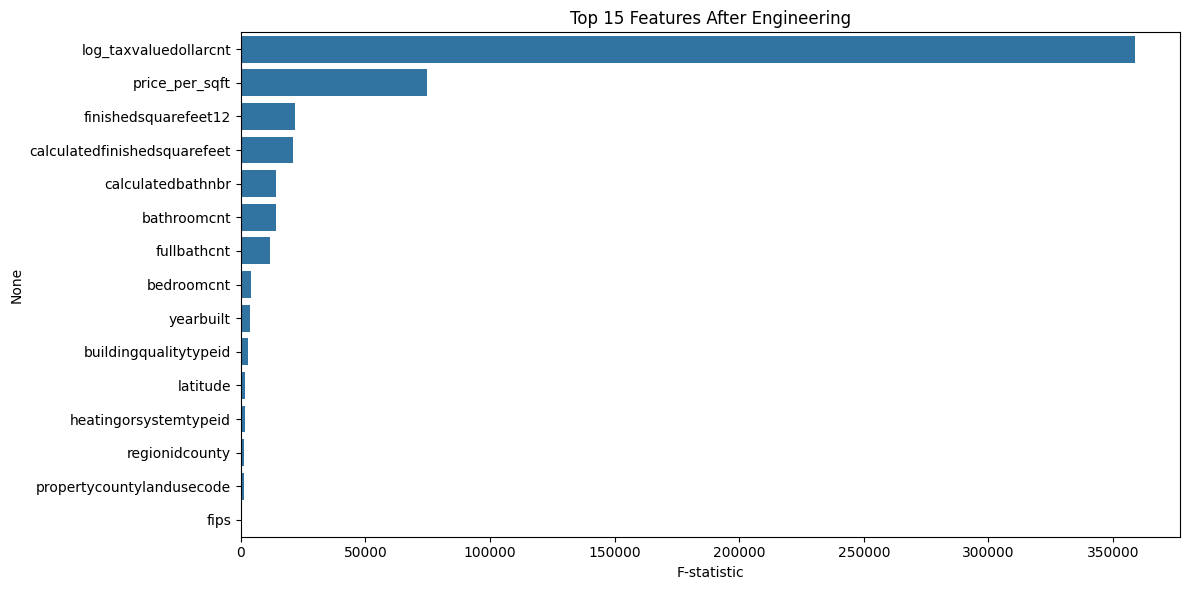

In [24]:
#added additional example to highlight top features after engineering has been completed
#using 'taxvaluedollarcnt' as the target column
X = df_scaled.drop(columns='taxvaluedollarcnt')
y = df_scaled['taxvaluedollarcnt']

#calc F-statistics,  sort
f_vals, _ = f_regression(X, y)
f_scores = pd.Series(f_vals, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=f_scores.head(15).values, y=f_scores.head(15).index)
plt.title("Top 15 Features After Engineering")
plt.xlabel("F-statistic")
plt.tight_layout()
plt.show()



#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed.


We applied three key transformations to better expose underlying patterns in the data.

First, we used a log transform on the target variable (taxvaluedollarcnt) because its original distribution was right-skewed, with a long tail of very high values. The histogram confirmed that taking the log helped compress these extremes and produced a more balanced distribution, which should help linear models capture relationships more effectively.

We introduced a derived feature—price per square foot—to highlight the relative value of each property’s living area. By dividing the total tax value by the finished square footage, we can compare properties of different sizes on a more uniform scale.

The side-by-side histogram for price_per_sqft showed that most properties cluster within a lower price range, with some higher-end outliers. We scaled numeric features (like finishedsquarefeet12) using a standard scaler to ensure they share a similar mean and variance. The “before and after” plots confirmed that the raw distribution was centered and narrowed around zero mean after scaling, which is often beneficial for algorithms sensitive to feature magnitude.

Lastly, as a team, we introduced F-Statistics as a fourth entry to highlight top 15 features after engineering has been completed. This was not required, but wanted to provide the additional insight.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

